# Compute the effects of solution on flows

This notebook illustrates the interface for computing the changes by solutions. For more detailed description of the why-s and how-s and the Solutions, see the notebooks with lower fm-number.

## The algorithm expects a graph (G) with these properties

+ vertices have unique IDs, stored in an internal vertex property called *id* (string)

+ there is only a single edge between two vertices (no parallels)

+ edges have an internal edge property called *flow*, which is a dictionary that must have:

    + *amount* : float
    
    + *composition* : dictionary of { material (string) : amount (float) }
    

## The algorithm expects the following input

Currently there are 6 parameters for computing changes on a graph. From these 6, 3 are required and 3 are optional. This second group is only needed when a flows needs to be shifted. For more details see `solution_object.json`

### Input

+ a graph (G) as described above, type `graph_tool.Graph`

+ a *solution object* as described by the `solution_object.json` schema

### Output

+ an Edge PropertyMap of the signed changes that is caused by the solution

In [15]:
import graph_tool as gt
from graph_tool import util
from graph_tool import stats as gt_stats
import graph_tool.search
from graph_tool import Edge, Graph, Vertex, PropertyMap
import graph_tool.draw

import cairo
import numpy as np
import datetime
from collections import namedtuple

import  os
os.chdir("/tmp") # the ./flow_modelling dir is mapped to /tmp in the Docker container

In [19]:
from pprint import pprint

In [2]:
print("Last run:", datetime.datetime.now().date().isoformat())

Last run: 2019-02-06


In [78]:
def find_vertex_index(G, vprop_id):
    """Finds the index of a vertex with the given ID property
    
    The order of the vertices traversed by the vertices() iterator 
    always corresponds to the vertex index ordering, as given by the vertex_index property map.
    
    vprop_id : int
        The vertex ID property
    
    Returns
    -------
    vertex index : int
    """
    assert isinstance(vprop_id, int)
    for i, v in enumerate(G.vertices()):
        if G.vp.id[v] == vprop_id:
            return i

def split_flows(G):
    """Split the flows based on material composition
    
    If a flow is composed of different materials, it is split into individual flows per material 
    with the corresponding amount.
    If the flow is composed of a single material, the composition property is removed and replaced with material.
    
    Returns
    -------
    graph
        The updated graph
    eprop_material
        Edge property (materials), string
    eprop_amount
        Edge property (amount), double
    eprop_amount_text
        Edge property (amount), string. Only needed for plotting the amounts on the edges with graph-tool
    """
    g = G.copy()
    g.clear_edges()
    del g.edge_properties['flow']
    eprops = G.edge_properties.keys()
    amount_list = []
    material_list = []
    assert 'flow' in eprops, "The graph must have 'flow' edge property"
    e_list = []
    for e in G.edges():
        prop = G.ep.flow[e]
        assert isinstance(prop, dict), "Edge property flow must be a dictionary in edge {}".format(e)
        for material, percent in prop['composition'].items():
            e_list.append(np.array([e.source(), e.target()], dtype=int))
            amount_list.append(float(prop['amount']) * float(percent))
            material_list.append(material)
    e_array = np.vstack(e_list)
    g.add_edge_list(e_array)
    eprop_amount = g.new_edge_property("float", vals=amount_list)
    eprop_amount_text = g.new_edge_property("string", vals=[round(i,2) for i in amount_list])
    eprop_material = g.new_edge_property("string", vals=material_list)
    return (g, eprop_material, eprop_amount, eprop_amount_text)


def filter_flows(G, solution_object):
    """Keep only the affected_flows and solution_flows in the graph"""
    edge_mask = G.new_edge_property("bool")
    if len(solution_object.solution_flows) > 0:
        assert isinstance(solution_object.solution_flows[0], tuple), "Flow must be a tuple of (edge id, material name)"
    elif len(solution_object.affected_flows) > 0:
        assert isinstance(solution_object.affected_flows[0], tuple), "Flow must be a tuple of (edge id, material name)"
    selected_flows = solution_object.affected_flows + solution_object.solution_flows
    for e in G.edges():
        eid = G.ep.id[e]
        mat = G.ep.material[e]
        key = (eid, mat)
        if key in selected_flows:
            edge_mask[e] = True
        else:
            edge_mask[e] = False
    return edge_mask


class NodeVisitor(gt.search.BFSVisitor):

    def __init__(self, name, solution, amount, visited, change):
        self.id = name
        self.solution = solution
        self.amount = amount
        self.visited = visited
        self.change = change

    def discover_vertex(self, u):
        """This is invoked when a vertex is encountered for the first time."""
        pass

    def examine_vertex(self, u):
        """Compute the amount change on each inflow for the vertex
        
        This function is invoked on a vertex as it is popped from the queue.

        Returns
        -------
        dict
            {edge : change}
        """
        changes = {}
        if u.in_degree() > 0:
            all_in = list(u.in_edges())
            for i,e in enumerate(all_in):
                if not self.visited[e]:
                    e_src = e.source()
                    e_src_out = [e for e in e_src.out_edges()]
                    if len(e_src_out) > 1:
                        # For the case when an inflow edge shares the source vertex
                        self.change[e] = ( self.amount[e] / sum([self.amount[out_f] for out_f in e_src_out]) ) * self.solution
                    else:
                        self.change[e] = ( self.amount[e] / sum([self.amount[in_f] for in_f in all_in]) ) * self.solution
                    #print(self.id[e.source()], '-->', self.id[e.target()], self.change[e])
                    self.visited[e] = True
        else:
            #print("source node,", u.vp.id)
            pass
        
def traverse_graph(G, solution_flows, include, solution, amount, upstream=True):
    """Traverse the graph in a breadth-first-search manner
    
    Parameters
    ----------
    G : the graph to explore
    solution_flows : the starting edges, normally this is the *solution_flows*
    include : edge propery map (bool) to indicate the edges that are part of the solution definition
    solution : double, the solution
    amount : edge property map (double) of the material amounts
    upstream : The direction of traversal. When upstream is True, the graph is explored upstream first, otherwise downstream first.  
    
    Returns
    -------
    Edge ProperyMap (float)
        The signed change on the edges
    """
    # Property map for keeping track of the visited edge. Once an edge has been visited
    # it won't be processed anymore.
    defaults = [(False,0.0) for x in range(G.num_edges(ignore_filter=True))]
    change_collection = {}
    
    for solution_edge_nr, edge_tuple in enumerate(solution_flows):
        change_collection[solution_edge_nr] = G.new_edge_property("float", vals=defaults[1])
        visited = G.new_edge_property("bool", vals=defaults[0])
        edge_id, edge_material = edge_tuple
        edges_same_id = util.find_edge(G, G.ep["id"], edge_id)
        edge_list = [e for e in edges_same_id if G.ep.material[e] == edge_material]
        assert len(edge_list) < 2, "(Edge ID: %s, material:%s) is not unique!" % (edge_id, edge_material)
        assert len(edge_list) == 1, "Could not find (Edge ID: %s, material:%s)" % (edge_id, edge_material)
        edge = edge_list[0]
        #G.edge_properties["change"] = change
        # By default we go upstream first, because 'demand dictates supply'
        if upstream:
            G.set_reversed(True)
        else:
            G.set_reversed(False)
        node = edge.target()
        # We are only interested in the edges that define the solution
        G.set_edge_filter(include)
        #print("\nTraversing in 1. direction")
        gt.search.bfs_search(G, node, NodeVisitor(G.vp["id"], solution, amount, visited, 
                                                  change_collection[solution_edge_nr]))
        if G.is_reversed():
            G.set_reversed(False)
        else:
            G.set_reversed(True)
        #print("\nTraversing in 2. direction")
        gt.search.bfs_search(G, node, NodeVisitor(G.vp["id"], solution, amount, visited, 
                                                  change_collection[solution_edge_nr]))
        del visited
        G.set_reversed(False)
        G.clear_filters()

    change = G.new_edge_property("float", vals=defaults[1])
    for edge in G.edges():
        change[edge] = sum([change_collection[solution_edge_nr][edge] 
                            for solution_edge_nr,edge_tuple in enumerate(solution_flows)])
    return change


def shift_flow(G, edge_to_remove, target_vertex, eprop_material, eprop_mass, eprop_mass_text):
    """Shifts a flow by removing an existing flow and adding a new flow
    
    Return
    ------
    graph
        (Copy of the graph with the shifted flow, copies of the property maps with the shifted flow)
    """
    assert isinstance(G, Graph)
    assert isinstance(edge_to_remove, Edge)
    assert isinstance(target_vertex, Vertex)
    assert isinstance(eprop_material, PropertyMap)
    assert isinstance(eprop_mass, PropertyMap)
    assert isinstance(eprop_mass_text, PropertyMap)
    
    g = G.copy()
    mat = g.new_edge_property("string", vals=eprop_material)
    mass = g.new_edge_property("float", vals=eprop_mass)
    mass_text = g.new_edge_property("string", vals=eprop_mass_text)
    
    edge_to_add = g.add_edge(edge_to_remove.source(), target_vertex)
    mat[edge_to_add] = eprop_material[edge_to_remove]
    mass[edge_to_add] = eprop_mass[edge_to_remove]
    mass_text[edge_to_add] = eprop_mass_text[edge_to_remove]
    g.remove_edge(edge_to_remove)
    
    return (g, edge_to_add, mat, mass, mass_text)


def compare_graphs(G1, G2):
    """Compare G2 to G1 and report the changes in vertices and edges"""
    assert "id" in G1.vertex_properties.keys()
    assert "id" in G2.vertex_properties.keys()
    vtx_removed = set(G1.vp["id"]) - set(G2.vp["id"])
    vtx_added = set(G2.vp["id"]) - set(G1.vp["id"])
    e_removed = [e for e in G1.edges() if e not in G2.edges()]
    e_added = [e for e in G2.edges() if e not in G1.edges()]
    
    print("Nodes removed from G1:", ", ".join(vtx_removed))
    print("Nodes added to G1:", ", ".join(vtx_added))
    print("\nFlows removed from G1:")
    for e in e_removed:
        print(G1.vp.id[e.source()], '-->', G1.vp.id[e.target()])
    print("\nFlows added to G1:")
    for e in e_added:
        print(G2.vp.id[e.source()], '-->', G2.vp.id[e.target()])
    pass


def apply_ratio(G, solution_edge, ratios, mass):
    """Apply the ratio to the flows
    
    Returns
    -------
    Edge PropertyMap
        Signed change of the amount
    """
    change_map = G.new_edge_property("float")
    v = solution_edge.target()
    for e in v.in_edges():
        if e != solution_edge:
            change = ( mass[solution_edge] * ratios[solution_edge] ) - mass[solution_edge]
            change_map[e] = change
            #print(G.vp.id[e.source()], '-->', G.vp.id[e.target()], change)
        else:
            change_map[e] = 0.0
    return change_map


def plot_sol_amount(g, amount, colors=None):
    amount_text = g.new_edge_property("string", vals=[round(i,2) for i in amount])
    if colors:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors}
    else:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC}
    pos = gt.draw.sfdp_layout(g)
    gt.draw.graph_draw(g, vertex_size=15, vertex_text=g.vp.id,
                       pos=pos,
                       vprops={"text_position":0.5, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops=eprops_p,
                       edge_text=amount_text,
                       output_size=(700,600), inline=True)

    
def plot_sol_materials(g, colors=None):
    if colors:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC, "color":colors}
    else:
        eprops_p = {"font_slant":cairo.FONT_SLANT_ITALIC}
    gt.draw.graph_draw(g, vertex_size=15, vertex_text=g.vp.id,
                       vprops={"text_position":0.5, "font_weight": cairo.FONT_WEIGHT_BOLD, "font_size":14},
                       eprops=eprops_p,
                       edge_text=g.ep.material,
                       output_size=(700,600), inline=True)

def print_flows(G):
    for i,e in enumerate(G.edges()):
        f = "id:%s; %s --> %s; material:%s; amount:%s"
        print(i, f % (G.ep.id[e], G.vp.name[e.source()], G.vp.name[e.target()], G.ep.material[e], G.ep.amount[e]))

In [5]:
G = gt.load_graph("keyflow-1-base.gt")

In [6]:
G.list_properties()

bvdid          (vertex)  (type: string)
id             (vertex)  (type: int32_t)
name           (vertex)  (type: string)
amount         (edge)    (type: int32_t)
id             (edge)    (type: int32_t)
material       (edge)    (type: string)


In [27]:
print_flows(G)

0 id:1; oil_rig_den_haag --> oil_refinery_rotterdam; material:Crude Oil; amount:5
1 id:2; oil_rig_rotterdam --> oil_refinery_rotterdam; material:Crude Oil; amount:15
2 id:3; oil_refinery_rotterdam --> production_utrecht; material:Plastic; amount:100
3 id:4; oil_refinery_rotterdam --> production_leiden; material:Plastic; amount:300
4 id:1; oil_refinery_rotterdam --> oil_refinery_rotterdam; material:Petrol; amount:1600
5 id:5; production_utrecht --> packaging_utrecht; material:Plastic; amount:125
6 id:6; production_leiden --> packaging_leiden; material:Plastic; amount:375
7 id:29; recycling_wageningen --> production_utrecht; material:Plastic; amount:50
8 id:30; recycling_wageningen --> production_leiden; material:Plastic; amount:50
9 id:2; recycling_wageningen --> recycling_wageningen; material:Other Waste; amount:100
10 id:17; ah_den_haag_1 --> incinerator_eindhoven; material:Other Waste; amount:100
11 id:20; ah_den_haag_1 --> paper_waste_collector_enschede; material:Other Waste; amount

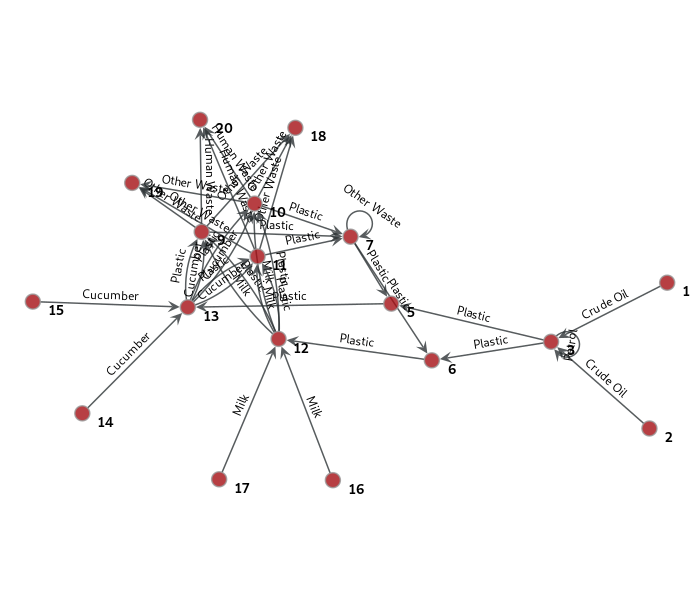

In [13]:
plot_sol_materials(G)

## Define the `solution_flows`

In [22]:
Solution = namedtuple('Solution', [
    'affected_flows',
    'solution_flows',
    'solution',
    'flow_to_remove',
    'target_vertex',
    'ratio'
])
Solution.__new__.__defaults__ = (None, None, 0.0, None, None, 0.0)
solutions = [
    Solution([(3, "Plastic"),(5, "Plastic"),(26, "Plastic"),(27, "Plastic"),(28, "Plastic"),(29, "Plastic")],
             [(11, "Plastic"),(12, "Plastic"),(13, "Plastic")],
             2),
    Solution([(1, "Crude Oil"), (2, "Crude Oil")],
             [],
             3),
    Solution([],
             [],
             4)
]

In [24]:
sol1 = solutions[0]
print(sol1)

Solution(affected_flows=[(3, 'Plastic'), (5, 'Plastic'), (26, 'Plastic'), (27, 'Plastic'), (28, 'Plastic'), (29, 'Plastic')], solution_flows=[(11, 'Plastic'), (12, 'Plastic'), (13, 'Plastic')], solution=2, flow_to_remove=None, target_vertex=None, ratio=0.0)


The procedure below simulates the user who selects the *solution_flows*. Required input:

+ material

+ ID of source vertex

+ ID of target vertex

Alternatively, we can use edge IDs instead of vertex IDs if that is easier to get.

In [15]:
affected_flows = []

# edge
material = 'Milk'
v_source = util.find_vertex(g_split, g_split.vp["id"], 16)
v_target = util.find_vertex(g_split, g_split.vp["id"], 12)
e = g_split.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if eprop_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (g_split.vp.id[v_source[0]], g_split.vp.id[v_target[0]])
affected_flows.extend(e_to_add)

v_source = util.find_vertex(g_split, g_split.vp["id"], 17)
v_target = util.find_vertex(g_split, g_split.vp["id"], 12)
e = g_split.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if eprop_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (g_split.vp.id[v_source[0]], g_split.vp.id[v_target[0]])
affected_flows.extend(e_to_add)

edge_mask, ecolors = define_mask(g_split, affected_flows)
for e in solution_flows:
    ecolors[e] = "blue"

In [58]:
edge_mask = filter_flows(G, solutions[0])

### Compute the changes

In [74]:
G.ep.amount

<PropertyMap object with key type 'Edge' and value type 'int32_t', for Graph 0x7fe420b9b898, at 0x7fe420b9b6a0>

In [79]:
changes = traverse_graph(G, solutions[0].solution_flows, edge_mask, solutions[0].solution, G.ep.amount, upstream=True)

In [9]:
for i,e in enumerate(G.edges()):
    if changes[e] != 0.0:
        print(G.vp.id[e.source()], '-->', G.vp.id[e.target()], changes[e])

Farm --> Packaging -26.0
Packaging --> Consumption -26.0
Consumption --> Waste -20.526315789473685
Consumption --> Waste 2 -5.473684210526315


In [81]:
for i,e in enumerate(G.edges()):
    if changes[e] != 0.0:
        print(G.vp.name[e.source()], '-->', G.vp.name[e.target()], changes[e])

oil_refinery_rotterdam --> production_utrecht 4.0
production_utrecht --> packaging_utrecht 6.0
recycling_wageningen --> production_utrecht 2.0
ah_den_haag_1 --> recycling_wageningen 0.75
ah_den_haag_2 --> recycling_wageningen 2.25
ah_den_haag_3 --> recycling_wageningen 3.0
packaging_utrecht --> ah_den_haag_1 2.0
packaging_utrecht --> ah_den_haag_2 3.0
packaging_utrecht --> ah_den_haag_3 1.0


### Apply the changes
Once the changes are computed, the new *amount* can be computed for each edge as *amount + change*

## 2. Computing add/remove flows

### Case of Bread to Beer

In [10]:
G = gt.load_graph("breadbeer.gt")

g_split, eprop_material, eprop_amount, eprop_amount_text = split_flows(G)

In [11]:
v_source = util.find_vertex(g_split, g_split.vp["id"], "Households")
v_target = util.find_vertex(g_split, g_split.vp["id"], "Incineration")
pe = g_split.edge(v_source[0], v_target[0], all_edges=True)
edge_to_remove = [e for e in pe if eprop_material[e] == 'bread'][0] # because there are prallel edges, we need to identify them by material

v_target = util.find_vertex(g_split, g_split.vp["id"], "Brewery")[0]

In [12]:
# Shift the flow Households-->Brewery
shifted_g, solution_edge, shifted_material, shifted_mass, shifted_mass_text = shift_flow(g_split, \
                                                                          edge_to_remove=edge_to_remove, \
                                                                          target_vertex=v_target, \
                                                                          eprop_material=eprop_material, \
                                                                          eprop_mass=eprop_amount, \
                                                                          eprop_mass_text=eprop_amount_text)

In [13]:
compare_graphs(g_split, shifted_g)

Nodes removed from G1: 
Nodes added to G1: 

Flows removed from G1:
Households --> Incineration

Flows added to G1:
Households --> Brewery


In [14]:
solution_edges = []

# edge
material = 'barley'
v_source = util.find_vertex(shifted_g, shifted_g.vp["id"], "Farm")
v_target = util.find_vertex(shifted_g, shifted_g.vp["id"], "Brewery")
e = shifted_g.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if shifted_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (shifted_g.vp.id[v_source[0]], shifted_g.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

# edge
material = 'bread'
v_source = util.find_vertex(shifted_g, shifted_g.vp["id"], "Households")
v_target = util.find_vertex(shifted_g, shifted_g.vp["id"], "Brewery")
e = shifted_g.edge(v_source[0], v_target[0], all_edges=True)
e_to_add = [edge for edge in e if shifted_material[edge] == material]
assert len(e_to_add) == 1, "There are parallel edges in %s --> %s" % (shifted_g.vp.id[v_source[0]], shifted_g.vp.id[v_target[0]])
solution_edges.extend(e_to_add)

edge_mask, ecolors = define_mask(shifted_g, solution_edges)
ecolors[solution_edge] = "blue"

In [15]:
ratios = shifted_g.new_edge_property("float")
ratios[solution_edge] = (3/5) * (1/2)

In [22]:
changes = apply_ratio(shifted_g, solution_edge, ratios, shifted_mass)

In [23]:
for i,e in enumerate(g_split.edges()):
    if changes[e] != 0.0:
        print(g_split.vp.id[e.source()], '-->', g_split.vp.id[e.target()], changes[e])

Farm --> Brewery -3.5
